# Info
Name:  

    COSR_DARE

Purpose:  

    To Build the COSR DARE calculations
  
Input:

    arguments
  
Output:

    Figure and save files
  
Keywords:

    none
  
Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - ...
  
Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2019-10-04
    Modified: 

# Prepare python environment

In [1]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
from datetime import datetime
from scipy.interpolate import UnivariateSpline, interp1d
from scipy import interpolate 
import pandas as pd

/usr/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [60]:
import Run_libradtran as RL
import os
import write_utils as wu

In [4]:
name = 'COSR'
vv = 'v1'

In [5]:
fp =getpath('COSR')

Return path named:  COSR /mnt/c/Users/lebla/Research/COSR/


In [6]:
day = '20180624'

In [7]:
#get the paths
fp_rtm = '/home/samuel/rtm/'
fpp_in = '/home/samuel/rtm/input/{}_CRE_{}/'.format(name,vv)
fpp_out = '/home/samuel/rtm/output/{}_CRE_{}/'.format(name,vv)
fp_uv = '/mnt/c/Users/lebla/Research/libradtran/libRadtran-2.0.2/bin/uvspec'

## Setup command line interface

In [6]:
import argparse

In [7]:
long_description = """    Prepare or save the direct Aerosol radiative effect files for calculations. """

In [32]:
parser = argparse.ArgumentParser(description=long_description)
parser.add_argument('-doread','--doread',help='if set, will only read the output, not produce them',
                    action='store_true')
parser.add_argument('-d','--daystr',nargs='?',help='The day string (yyyymmdd) for the desired flight data. Defaults to 20180624')

_StoreAction(option_strings=['-d', '--daystr'], dest='daystr', nargs='?', const=None, default=None, type=None, choices=None, help='The day string (yyyymmdd) for the desired flight data. Defaults to 20180624', metavar=None)

In [9]:
in_ = vars(parser.parse_args())
do_read = in_.get('doread',False)
day = in_.get('daystr','20180624')

usage: ipykernel_launcher.py [-h] [-doread]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/sleblanc/.local/share/jupyter/runtime/kernel-675fec48-fd38-4288-acae-f5ab90ce1cf4.json


SystemExit: 2

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Load files

## Load the in situ files

In [8]:
situ = pd.read_csv(fp+'data_other/{}_nephclap.csv'.format(day))

In [9]:
situ

,DateTimeUTC,totScat_450nm,totScatCalc_500nm,totScat_550nm,totScat_700nm,scatFitSlope,scatFitIncpt,angScat,totAbs_467nm,totAbsCalc_500nm,totAbs_528nm,totAbs_652nm,absFitSlope,absFitIncpt,angAbs,extCalc500nm
0,2018-06-24 14:14:00,1.80,1.402245,1.17,0.52,-2.828733,17.917542,2.828733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-06-24 14:15:00,1.43,1.281489,1.28,0.59,-2.043880,12.949936,2.043880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-06-24 14:16:00,1.81,1.484451,1.24,0.79,-1.876155,12.054614,1.876155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-06-24 14:17:00,2.00,1.672541,1.47,0.82,-2.031338,13.138311,2.031338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-06-24 14:18:00,2.32,1.898734,1.55,1.10,-1.680126,11.082512,1.680126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-06-24 14:19:00,2.32,1.908862,1.64,0.92,-2.103533,13.719140,2.103533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-06-24 14:20:00,2.21,2.037622,2.06,1.09,-1.634308,10.868368,1.634308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-06-24 14:20:58,3.79,3.130448,3.22,0.71,-3.873120,25.211101,3.873120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-06-24 14:20:59,4.10,3.137733,2.52,1.21,-2.771368,18.366468,2.771368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-06-24 14:21:00,3.91,2.798897,2.09,0.92,-3.279057,21.407277,3.279057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
insitu = situ.to_dict('list')

In [11]:
insitu.keys()

['totScat_450nm',
 'totScat_700nm',
 'scatFitSlope',
 'totScat_550nm',
 'totAbs_528nm',
 'totAbs_467nm',
 'totAbsCalc_500nm',
 'totAbs_652nm',
 'totScatCalc_500nm',
 'DateTimeUTC',
 'angScat',
 'angAbs',
 'absFitSlope',
 'extCalc500nm',
 'absFitIncpt',
 'scatFitIncpt']

In [12]:
insitu['ssa_500nm'] = np.array(insitu['totScatCalc_500nm'])/np.array(insitu['extCalc500nm'])

<IPython.core.display.Javascript object>


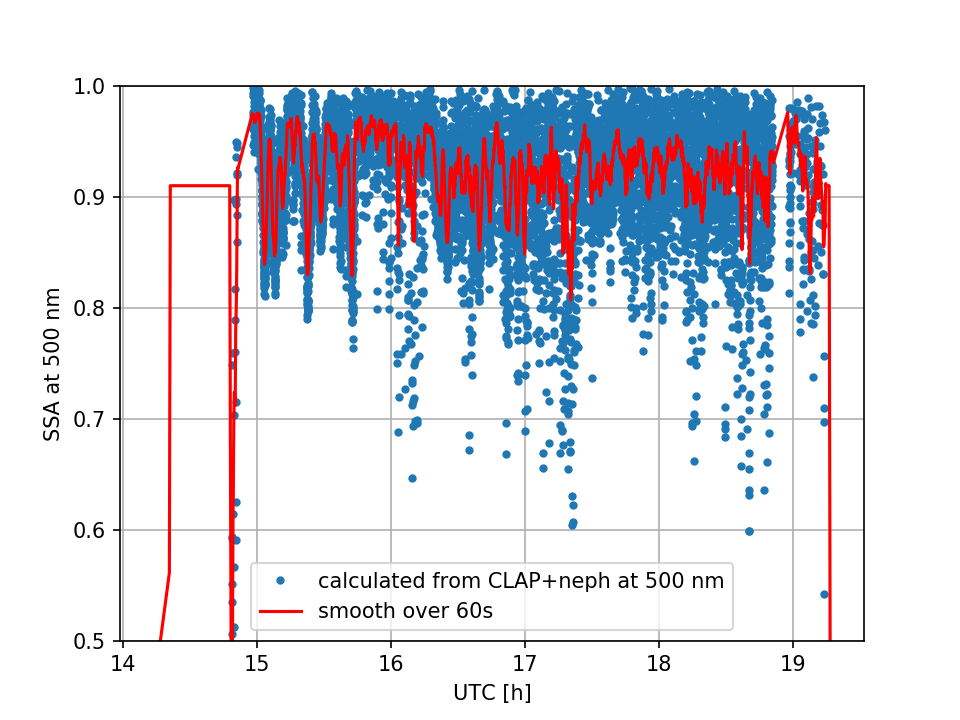

In [228]:
plt.figure()
plt.plot(insitu['utc'],insitu['ssa_500nm'],'.',label='calculated from CLAP+neph at 500 nm')
plt.plot(insitu['utc'],Sp.smooth(insitu['ssa_500nm'],60,old=True),'-r',label='smooth over 60s')
plt.legend()
plt.xlabel('UTC [h]')
plt.ylabel('SSA at 500 nm')
plt.ylim(0.5,1.0)
plt.grid()
plt.savefig(fp+'plots/SSA_500_CLAP_neph_smooth_{}.png'.format(day),dpi=600,transparent=True)

In [17]:
ssa_insitu = Sp.smooth(insitu['ssa_500nm'],60,old=True)

In [18]:
len(ssa_insitu)

17758

## Load the 4STAR AOD

In [139]:
s = sio.loadmat(fp+'os_data/4STAR_{}starsun.mat'.format(day))

In [335]:
s.keys()

['El_gnd',
 'Str',
 'tau_O3_err',
 'sza',
 'nirfilen',
 'toggle',
 'pitch',
 'Tst',
 'cwv',
 'fwhm',
 'flagsO3',
 'nirt',
 'tau_aero_noscreening',
 'rateaero',
 'O3h',
 'NO2col',
 'Headng',
 'RH',
 'Pst',
 'tau_aero_subtract_all',
 'nirheader',
 'nirdatatype',
 'sd_aero_crit',
 'tau_aero_err',
 'dark',
 'nirVdettemp',
 'Elstep',
 'tau_ray',
 'nircols',
 'sunaz',
 'O3col',
 'm_ray',
 'm_err',
 'forj_corr',
 'tau_O4_err',
 'flagsNO2',
 't',
 'c0mod',
 'tau_tot_slant',
 'track_err',
 'rate',
 'daystr',
 'program_version',
 'sat_time',
 'm_O3',
 'tau_aero_err2',
 'visheader',
 'Az_deg',
 'nirTint',
 'filename',
 'tau_r_err',
 'nirsat_pixel',
 'Md',
 'aeronetcols',
 'rateslant',
 'visAVG',
 'tau_NO2_err',
 'Zn',
 'AZstep',
 'darkstd',
 'visdatatype',
 'QdVtot',
 'tau_aero_err7',
 'tau_aero_err6',
 'tau_aero_err5',
 'nirAVG',
 'tau_tot_vert',
 'sun_sky_Az_offset',
 'w',
 'ELcorr',
 'visVdettemp_C',
 'tau_aero_err8',
 'El_deg',
 'skyresp',
 'Lon',
 'tau_aero',
 'w_isubset_for_polyfit',
 'AZ_d

In [140]:
s['utc'] = lu.toutc(lu.mat2py_time(s['t']))

### use the polyfit aod on the wavelength array

In [141]:
s['tau_aero_polynomial'].shape

(17661, 3)

In [142]:
wvl = np.array([0.25,0.35,0.4,0.5,0.675,0.87,0.995,1.2,1.4,1.6,2.1,3.2,4.9])

In [143]:
s['aod'] = np.zeros((len(s['utc']),len(wvl)))
for i in xrange(len(s['utc'])):
    s['aod'][i,:] = np.exp(np.polyval([s['tau_aero_polynomial'][i,0],s['tau_aero_polynomial'][i,1],
                                       s['tau_aero_polynomial'][i,2]],
                                         np.log(wvl)))


In [144]:
s['aod'].shape

(17661, 13)

In [145]:
s['aod'][10:-1:200,:].shape

(89, 13)

<IPython.core.display.Javascript object>


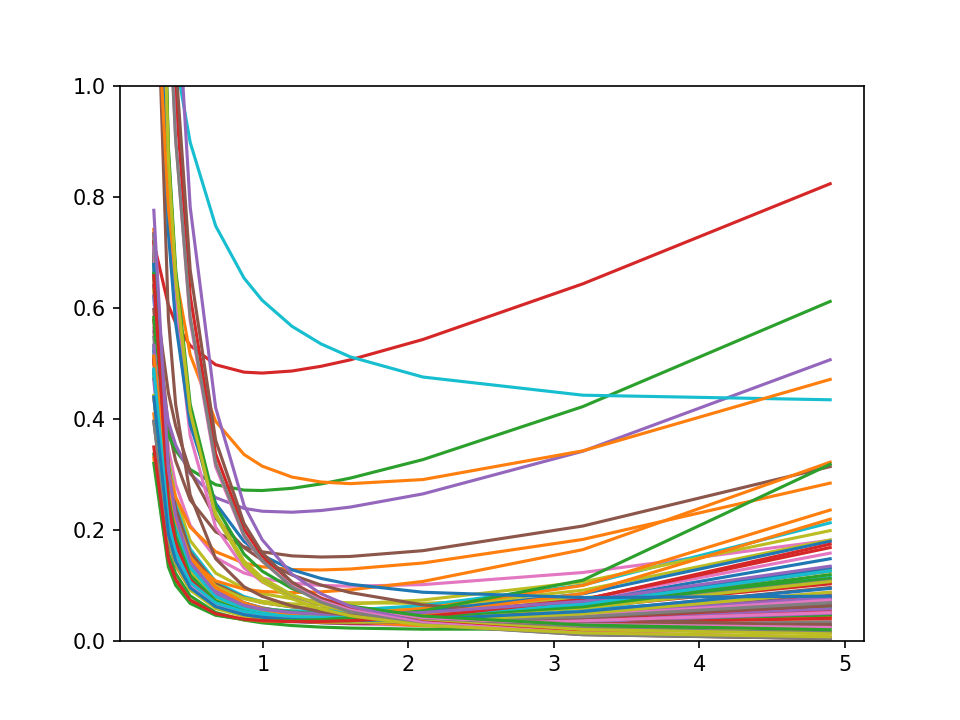

(0, 1)

In [97]:
plt.figure()
plt.plot(wvl,s['aod'][10:-1:200,:].T)
plt.ylim(0,1)

### Load the flag files

In [28]:
fmat = getpath('4STAR_data')

Return path named:  4STAR_data /mnt/c/Users/lebla/Research/4STAR_codes/data_folder//


In [29]:
with open (fmat+'starinfo_{}.m'.format(day), 'rt') as in_file:
    for line in in_file:
        if 'flagfilename ' in line:
            ff = line.split("'")[1]
sf = hs.loadmat(fmat+ff)

In [30]:
sf.keys()

[u'unspecified_clouds',
 u'manual_flags',
 u'bad_aod',
 u'flagfile',
 u'screen',
 u'frost',
 u'before_or_after_flight',
 u'unspecified_aerosol',
 u'hor_legs',
 u'flags',
 u'low_cloud',
 u'smoke',
 u'time',
 u'dust',
 u'vert_legs',
 u'screened',
 u'cirrus']

In [31]:
flag = sf['manual_flags']['good'][0,:,0]

In [32]:
flag.shape

(17661,)

In [33]:
sum(flag)

12608

## Load the skyscan results

In [34]:
fp_name = '4STAR_20180624_135_SKYP.created_20190329_003621.ppl_lv15.mat'
sky = sio.loadmat(fp+fp_name)

In [35]:
sky.keys()

['sky_radiances_pct_diff',
 'ext_fine',
 'flux_dn',
 'Sphericity_err',
 'Sphericity',
 'sky_radiances_angle',
 'sky_radiances_measured',
 'ssa_total',
 'radius',
 'flux_diffuse',
 'sfc_alb',
 'input_fname',
 'ssa_coarse',
 'sky_bias',
 'aaod',
 'fstem',
 'tod_fit',
 'output_fname',
 'g_coarse',
 'tod_meas',
 'input',
 'PF_coarse',
 'PF_total',
 'PF_fine',
 'aod',
 'g_fine',
 'refractive_index_real_r',
 'refractive_index_imaginary_r',
 'tod_meas_less_fit',
 'g_tot',
 'psd',
 'Wavelength',
 'PF_angle',
 '__version__',
 'ext_coarse',
 'ext_total',
 '__header__',
 '__globals__',
 'flux_up',
 'ssa_fine',
 'sky_radiances_fit',
 'sky_error']

# Plot out some data

## Plot out the retrieved skyscans

<IPython.core.display.Javascript object>


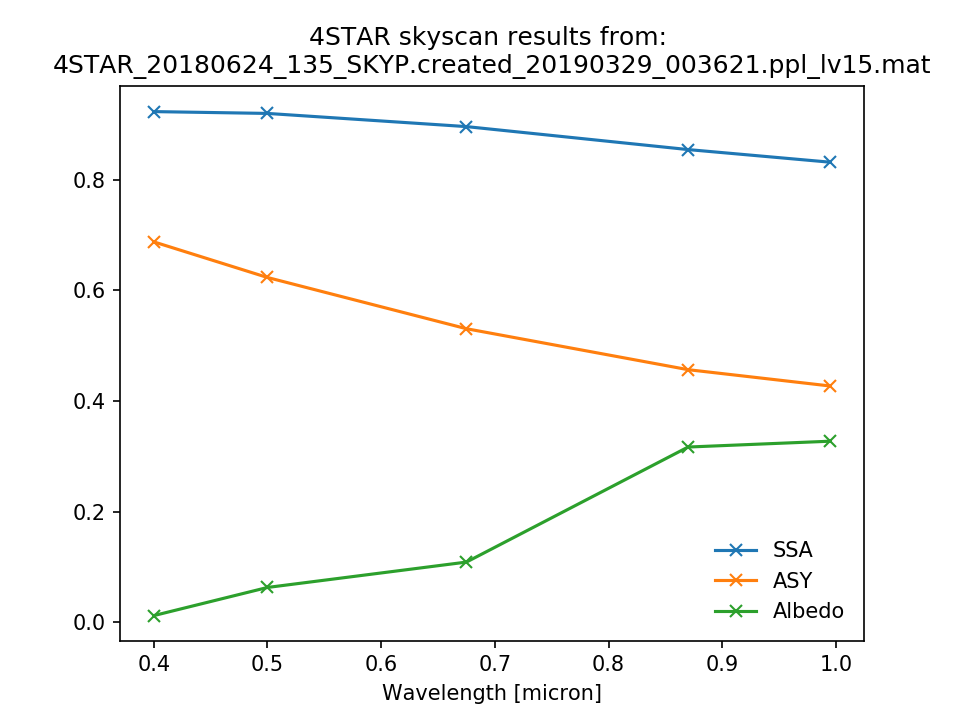

In [36]:
plt.figure()
plt.plot(sky['Wavelength'],sky['ssa_total'][0,:],'x-',label='SSA')
plt.plot(sky['Wavelength'],sky['g_tot'][0,:],'x-',label='ASY')
plt.plot(sky['Wavelength'],sky['sfc_alb'][0,:],'x-',label='Albedo')


plt.legend(frameon=False)
plt.xlabel('Wavelength [micron]')
plt.title('4STAR skyscan results from: \n' + fp_name)
plt.savefig(fp+'plots/4STAR_skyscan_result_{}_135_SKYP.png'.format(day),dpi=600,transparent=True)

In [37]:
sky['g_tot'][-1]

array([0.68756599, 0.62320095, 0.53069208, 0.45669369, 0.42719806])

In [98]:
#wvl = np.array([0.35,0.4,0.5,0.675,0.87,0.995,1.2,1.4,1.6,2.1,4.0])
f_asy = interp1d(np.append(sky['Wavelength'][:,0],[1.1,1.2]),np.append(sky['g_tot'][0,:],[sky['g_tot'][0,-1]-0.008,sky['g_tot'][0,-1]-0.011]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
asy = f_asy(wvl)
f_ssa = interp1d(np.append(sky['Wavelength'][:,0],[1.1,1.2,1.3]),np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]-0.008,sky['ssa_total'][0,-1]-0.01,sky['ssa_total'][0,-1]-0.014]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
ssa = f_ssa(wvl)
f_alb = interp1d(np.append(sky['Wavelength'][:,0],1.1),np.append(sky['sfc_alb'][0,:],sky['sfc_alb'][0,-1]+0.003),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
alb = f_alb(wvl)

In [99]:
np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]-0.008,sky['ssa_total'][0,-1]-0.002])

array([0.9229, 0.9196, 0.8958, 0.8543, 0.8315, 0.8235, 0.8295])

<IPython.core.display.Javascript object>


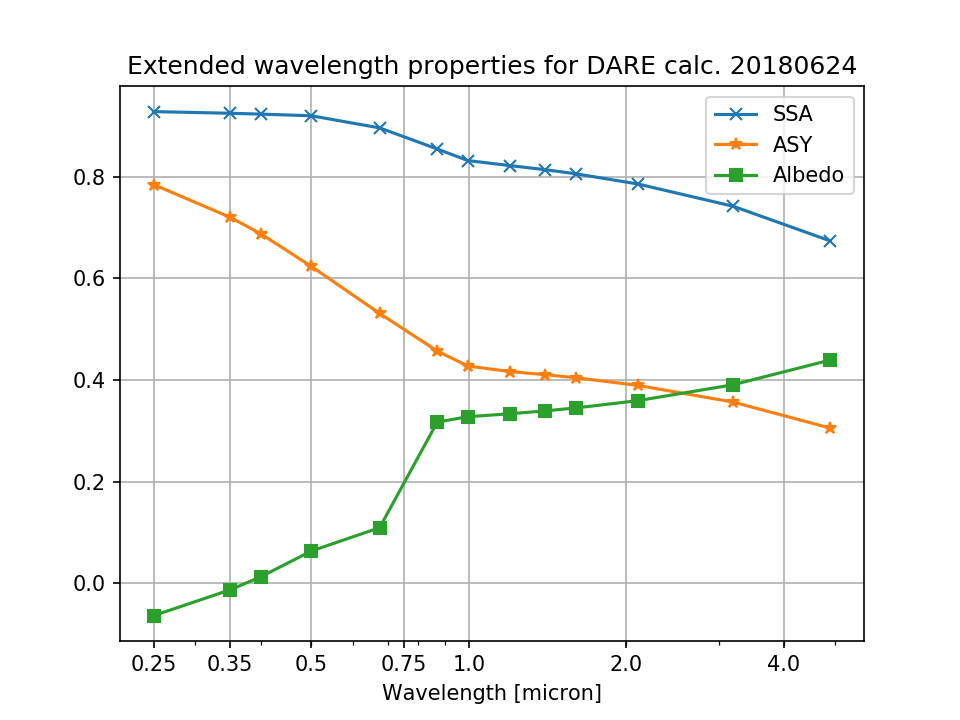

In [210]:
plt.figure()
plt.plot(wvl,ssa,'-x',label='SSA')
plt.plot(wvl,asy,'-*',label='ASY')
plt.plot(wvl,alb,'-s',label='Albedo')
plt.xscale('log')
plt.xticks([0.25,0.35,0.5,0.75,1.0,2.0,4.0],[0.25,0.35,0.5,0.75,1.0,2.0,4.0])
plt.grid()
plt.legend()
plt.xlabel('Wavelength [micron]')
plt.title('Extended wavelength properties for DARE calc. {}'.format(day))
plt.savefig(fp+'plots/AERO_prop_for_DARE_{}.png'.format(day),dpi=600,transparent=True)

## Get the vertical dependence of the extinction

In [101]:
gu = pd.to_datetime(situ['DateTimeUTC']).to_list()
insitu['utc'] = np.array([g.hour+g.minute/60.0+g.second/3600.0 for g in gu])

In [102]:
from scipy.interpolate import interp1d

In [103]:
f_alt = interp1d(x=s['utc'],y=s['Alt'][:,0])
insitu['alt'] = f_alt(insitu['utc'])

<IPython.core.display.Javascript object>


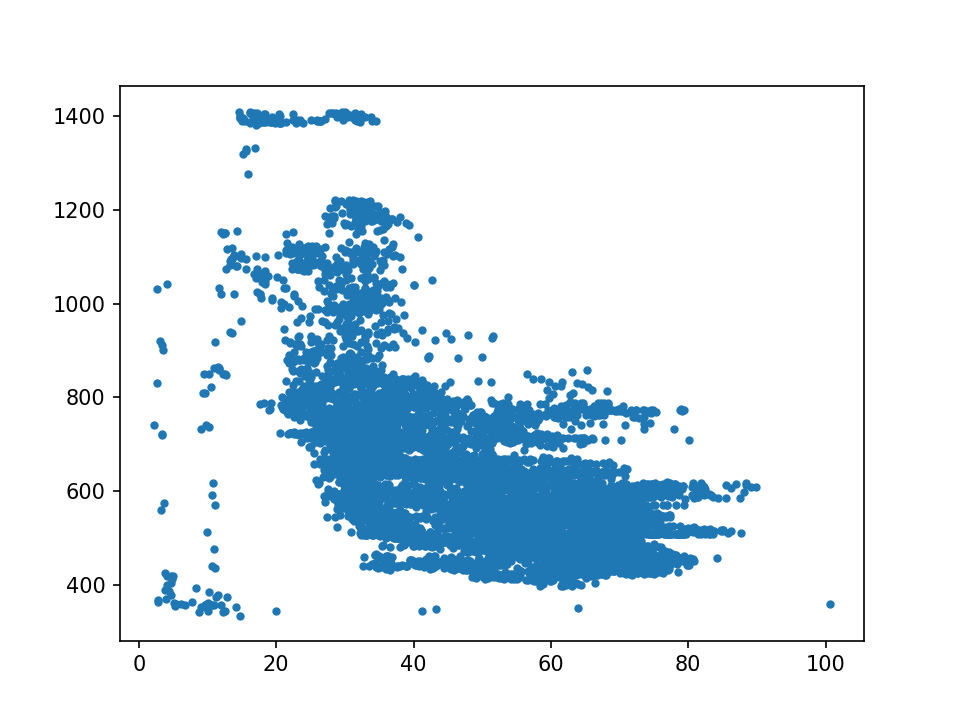

In [44]:
plt.figure()
plt.plot(insitu['extCalc500nm'],insitu['alt'],'.')

<IPython.core.display.Javascript object>


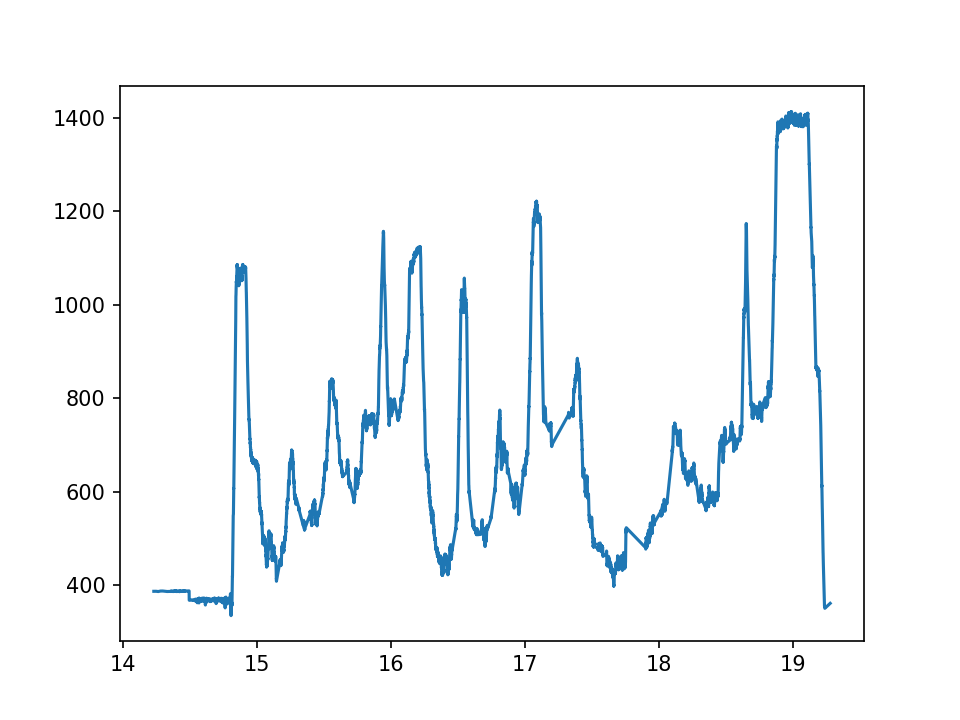

In [45]:
plt.figure()
plt.plot(insitu['utc'],insitu['alt'])

In [104]:
insitu['extCalc500nm'] = np.array(insitu['extCalc500nm'])

<IPython.core.display.Javascript object>


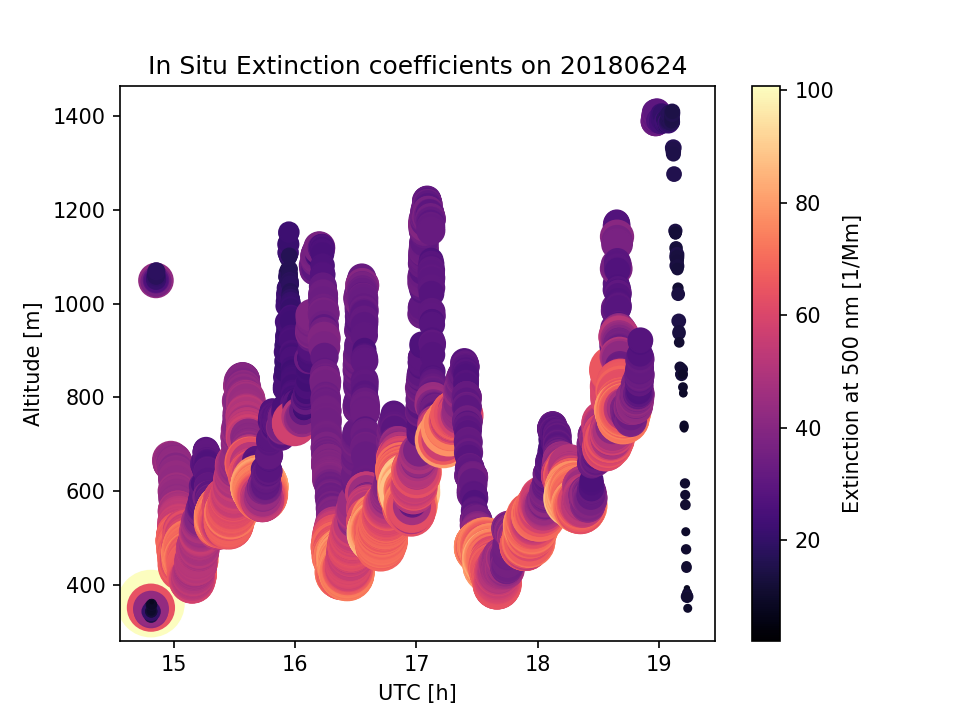

In [213]:
plt.figure()
plt.scatter(insitu['utc'],insitu['alt'],c=insitu['extCalc500nm'],cmap=plt.cm.magma,s=(insitu['extCalc500nm'])**1.5-20.0)
cb = plt.colorbar()
cb.set_label('Extinction at 500 nm [1/Mm]')
plt.xlabel('UTC [h]')
plt.ylabel('Altitude [m]')
plt.title('In Situ Extinction coefficients on {}'.format(day))
plt.savefig(fp+'plots/Extinction_UTC_{}.png'.format(day),dpi=600,transparent=True)

In [48]:
np.isfinite(insitu['extCalc500nm'])

array([False, False, False, ..., False, False, False])

In [50]:
binned_ext,binned_alt,binned_num = [],[],[]
for i in xrange(14):
    flaa = (insitu['alt']>=i*100.0) & (insitu['alt']<(i+1.0)*100.0) & (np.isfinite(insitu['extCalc500nm']))
    if flaa.any():
        binned_ext.append(insitu['extCalc500nm'][flaa])
        binned_alt.append(np.mean([i*100.0,(i+1.0)*100.0]))
        binned_num.append(len(insitu['extCalc500nm'][flaa]))

<IPython.core.display.Javascript object>


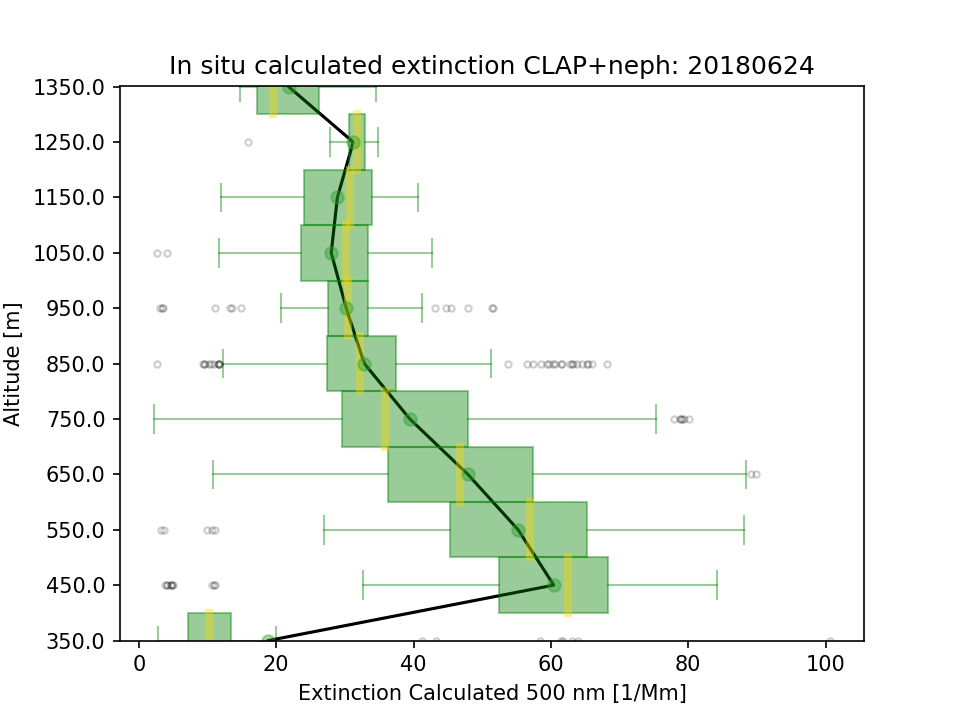

In [108]:
plt.figure()
bp =plt.boxplot(binned_ext,positions=binned_alt,vert=False,showfliers=True,widths=100,showmeans=True,patch_artist=True)
plt.xlabel('Extinction Calculated 500 nm [1/Mm]')
plt.ylabel('Altitude [m]')
#plt.plot(s['angs_470_865'][s['fl_QA_angs']],s['GPS_Alt'][s['fl_QA_angs']],'.',alpha=0.005)
for b in bp['boxes']:
    b.set_facecolor('green')
    b.set_edgecolor('green')
    b.set_alpha(0.4)
for b in bp['means']:
    b.set_marker('o')
    b.set_color('firebrick')
    b.set_alpha(0.4)
for b in bp['whiskers']:
    b.set_linestyle('-')
    b.set_color('green')
    b.set_alpha(0.4)
for b in bp['caps']:
    b.set_alpha(0.4)
    b.set_color('green')
for b in bp['medians']:
    b.set_linewidth(4)
    b.set_color('gold')
    b.set_alpha(0.4)
for b in bp['fliers']:
    b.set_marker('.')
    b.set_alpha(0.2)
ext_means = np.array([[b.get_data()[0][0],b.get_data()[1][0]] for b in bp['means']])
plt.plot(ext_means[:,0],ext_means[:,1],'-k')
plt.title('In situ calculated extinction CLAP+neph: {}'.format(day))
plt.savefig(fp+'plots/extinction_vertical_bins_clap_neph_{}.png'.format(day),dpi=600,transparent=True)

In [109]:
ext_z = ext_means[:,1]/1000.0
ext_ = ext_means[:,0]/1000.0
aod_ = ext_.sum()/10.0

In [110]:
ext_z = np.append(ext_z,ext_z[-1]+0.1)

In [111]:
nz = len(ext_z)

In [112]:
ext_ = np.append(ext_,ext_[-1]*0.0)

In [113]:
ext_,aod_

(array([0.01887655, 0.06041367, 0.05522762, 0.04790876, 0.03946096,
        0.03283407, 0.03020106, 0.02801399, 0.02891071, 0.03121669,
        0.02179804, 0.        ]), 0.03948621247357574)

# Now build the input files for DARE calculations


In [55]:
from tqdm.notebook import tqdm

In [114]:
geo = {'zout':[0,3,100],'year':2018,'month':6,'day':24,'hour':12,'minute':0,'second':0}
aero_base = {'z_arr':(ext_z+0.05),'wvl_arr':wvl,'ssa':np.array([ssa,]*nz),'asy':np.array([asy,]*nz)}
source = {'integrate_values':True,'dat_path':'/mnt/c/Users/lebla/Research/libradtran/libRadtran-2.0.2/data/',
          'run_fuliou':True,'wvl_range':[350,4000]}
albedo = {'create_albedo_file':True,'alb':alb,'alb_wvl':wvl*1000.0}
cloud = {'dummy':None}

In [115]:
fx_ssa_insitu = interp1d(insitu['utc'],ssa_insitu,bounds_error=False)
ssa_u = fx_ssa_insitu(s['utc'])
ssa_u[ssa_u<0.8] = np.nan

/home/samuel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [116]:
def expand_ext_vert_and_spect(ext_,ext_z,aod_sp,alt,wvl):
    """
    create a 2d array of extintion (altitude, spectra). 
    Inputs:
        ext_: vertical profile of ext, 
        ext_z: altitudes of profile [km], 
        aod_sp: aod spectra, 
        alt: measured alt [km]
        wvl: wavelength array of the aod_sp [microns]
    """
    iz = np.argmin(abs(ext_z-alt))
    iw = np.argmin(abs(wvl-0.5))
    aod_ = ext_[iz:].sum()/10.0
    
    factor = aod_sp[iw]/aod_
    exts = np.array([aod_sp*e for e in ext_])*factor
    return exts 

In [122]:
file_list = file(fp_rtm+'COSR_DARE_list_file_{d}_{v}.sh'.format(d=day,v=vv),'w')
file_list_clean = file(fp_rtm+'COSR_DARE_list_file_clean_{d}_{v}.sh'.format(d=day,v=vv),'w')
print 'Starting list file'
fpp_out = fp_rtm+'output/COSR_{d}_{v}/'.format(d=day,v=vv)
fpp_in = fp_rtm+'input/COSR_{d}_{v}/'.format(d=day,v=vv)
if not os.path.exists(fpp_out):
    os.mkdir(fp_out)
if not os.path.exists(fpp_in):
    os.mkdir(fp_in)

nu = len(s['utc'])
pbar = tqdm(total=nu)
for i,u in enumerate(s['utc']):
    aero = {}
    if flag[i] & np.isfinite(ssa_u[i]):
        aod = s['aod'][i,:]
        aero['ext'] = expand_ext_vert_and_spect(ext_,ext_z,s['aod'][i,:],s['Alt'][i]/1000.0,wvl)
        iw = np.argmin(abs(aero_base['wvl_arr']-0.5))
        aero['ssa'] = aero_base['ssa']*ssa_u[i]/aero_base['ssa'][0,iw]
        aero['asy'] = aero_base['asy']
        aero['z_arr'] = aero_base['z_arr']
        aero['wvl_arr'] = aero_base['wvl_arr']*1000.0
        
        try: aero['ssa'][aero['ssa']<0.0] = 0.0
        except: pass
        try: aero['ssa'][aero['ssa']>1.0] = 1.0
        except: pass
        try: aero['asy'][aero['asy']<0.0] = 0.0
        except: pass
        try: aero['asy'][aero['asy']>1.0] = 1.0
        except: pass
        try: aero['ext'][aero['ext']<0.0] = 0.0
        except: pass
        
        geo['utc'] = u
        geo['sza'] = s['sza'][i]
        geo['lat'] = s['Lat'][i]
        geo['lon'] = s['Lon'][i]
        
        fname = 'COSR_DARE_{d}_{v}_{i:06d}.dat'.format(d=day,v=vv,i=i)
        RL.write_input_aac(fpp_in+fname,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True,solver='twostr')
        
        file_list.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+fname,out=fpp_out+fname))
        
        fnamec = 'COSR_DARE_{d}_{v}_{i:06d}_clean.dat'.format(d=day,v=vv,i=i)
        aero.pop('ext',None)
        RL.write_input_aac(fpp_in+fnamec,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True,solver='twostr')
        
        file_list_clean.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+fnamec,out=fpp_out+fnamec))
    pbar.update(1)
    #print '{} / {}'.format(i,nu)
file_list.close()
file_list_clean.close()
print 'done'

Starting list file


/home/samuel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/home/samuel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/home/samuel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less


done


In [118]:
aero_base['z_arr']

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5])

In [119]:
ext_z

array([0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35,
       1.45])

## Now read the libradtran output files

In [188]:
out = {'ssa':[],'asy':[],'ext':[],'albedo':alb,'aod':[],'alt':[],
       'sza':[],'utc':[],'lat':[],'lon':[],'wvl':wvl,'z_aero':aero_base['z_arr']}

In [189]:
nzout = len(geo['zout'])

In [190]:
fl = flag & (np.isfinite(ssa_u))

In [191]:
nl = fl.sum()

In [192]:
star_aero = {'dn':np.zeros((nl,nzout))+np.nan,'up':np.zeros((nl,nzout))+np.nan}
star_aero_cl = {'dn':np.zeros((nl,nzout))+np.nan,'up':np.zeros((nl,nzout))+np.nan}
star_aero_C = np.zeros((nl,nzout))+np.nan

In [193]:
nu = len(s['utc'])
pbar = tqdm(total=nu)
print 'Reading files'
j = 0
for i,u in enumerate(s['utc']):
    aero = {}
    if flag[i] & np.isfinite(ssa_u[i]):
        aod = s['aod'][i,:]
        aero['ext'] = expand_ext_vert_and_spect(ext_,ext_z,s['aod'][i,:],s['Alt'][i]/1000.0,wvl)
        iw = np.argmin(abs(aero_base['wvl_arr']-0.5))
        aero['ssa'] = aero_base['ssa']*ssa_u[i]/aero_base['ssa'][0,iw]
        aero['asy'] = aero_base['asy']
        aero['z_arr'] = aero_base['z_arr']
        aero['wvl_arr'] = aero_base['wvl_arr']*1000.0
        
        try: aero['ssa'][aero['ssa']<0.0] = 0.0
        except: pass
        try: aero['ssa'][aero['ssa']>1.0] = 1.0
        except: pass
        try: aero['asy'][aero['asy']<0.0] = 0.0
        except: pass
        try: aero['asy'][aero['asy']>1.0] = 1.0
        except: pass
        try: aero['ext'][aero['ext']<0.0] = 0.0
        except: pass
        
        out['utc'].append(u)
        out['sza'].append(s['sza'][i])
        out['lat'].append(s['Lat'][i])
        out['lon'].append(s['Lon'][i])
        out['alt'].append(s['Alt'][i])
        out['ext'].append(aero['ext'])
        out['ssa'].append(aero['ssa'])
        out['asy'].append(aero['asy'])
        out['aod'].append(aod)
        
        
        fname = 'COSR_DARE_{d}_{v}_{i:06d}.dat'.format(d=day,v=vv,i=i)
        sa = RL.read_libradtran(fpp_out+fname,zout=geo['zout'])
        star_aero['dn'][j,:] = sa['diffuse_down']+sa['direct_down']
        star_aero['up'][j,:] = sa['diffuse_up']
        
        fnamec = 'COSR_DARE_{d}_{v}_{i:06d}_clean.dat'.format(d=day,v=vv,i=i)
        sc = RL.read_libradtran(fpp_out+fnamec,zout=geo['zout'])
        star_aero_cl['dn'][j,:] = sc['diffuse_down']+sc['direct_down']
        star_aero_cl['up'][j,:] = sc['diffuse_up']
        
        star_aero_C[j,:] = (star_aero['dn'][j,:]-star_aero['up'][j,:]) - \
                           (star_aero_cl['dn'][j,:]-star_aero_cl['up'][j,:])
        j = j +1
    pbar.update(1)

out['utc'] = np.array(out['utc'])
out['sza'] = np.array(out['sza'])
out['lat'] = np.array(out['lat'])
out['lon'] = np.array(out['lon'])
out['alt'] = np.array(out['alt'])
out['ext'] = np.array(out['ext'])
out['ssa'] = np.array(out['ssa'])
out['asy'] = np.array(out['asy'])
out['aod'] = np.array(out['aod'])
out['dare'] = star_aero_C
out['dn_aero'] = star_aero['dn']
out['up_aero'] = star_aero['up']
out['dn_clear'] = star_aero_cl['dn']
out['up_clear'] = star_aero_cl['up']

print 'done'

Reading files


/home/samuel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/home/samuel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/home/samuel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


done


In [194]:
#star = wu.iterate_dict_unicode(out)
out['zout'] = geo['zout']
print 'saving file to: '+fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d=day,vv=vv)
hs.savemat(fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d=day,vv=vv),out)

saving file to: /mnt/c/Users/lebla/Research/COSR/COSR_DARE_20180624_v1.mat


# Now plot out the DARE for this flight

In [195]:
out['dare'].shape

(8612, 3)

In [196]:
out['aod'].shape

(8612, 13)

<IPython.core.display.Javascript object>


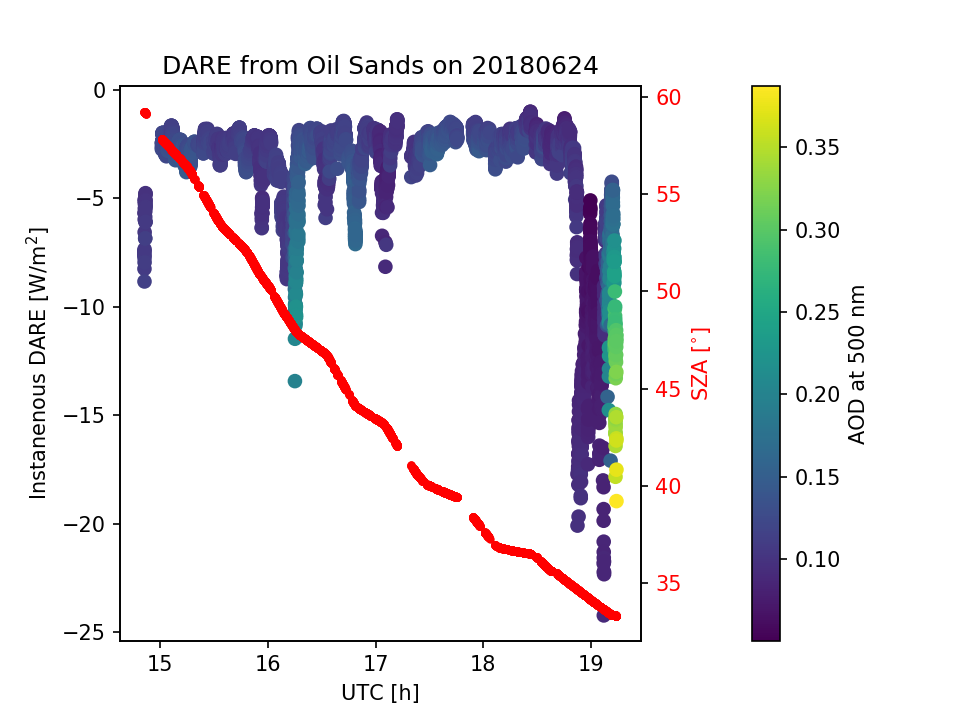

In [221]:
plt.figure()
plt.scatter(out['utc'],out['dare'][:,0],c=out['aod'][:,3])
plt.xlabel('UTC [h]')
plt.ylabel('Instanenous DARE [W/m$^2$]')
ax2 = plt.gca().twinx()
ax2.plot(out['utc'],out['sza'],'.r')
ax2.set_ylabel('SZA [$^{{\\circ}}$]',color='r')
ax2.tick_params(axis='y', labelcolor='r')
cb = plt.colorbar( pad=0.15)
cb.set_label('AOD at 500 nm')

plt.title('DARE from Oil Sands on {}'.format(day))
plt.savefig(fp+'plots/DARE_aod_utc_{}.png'.format(day),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


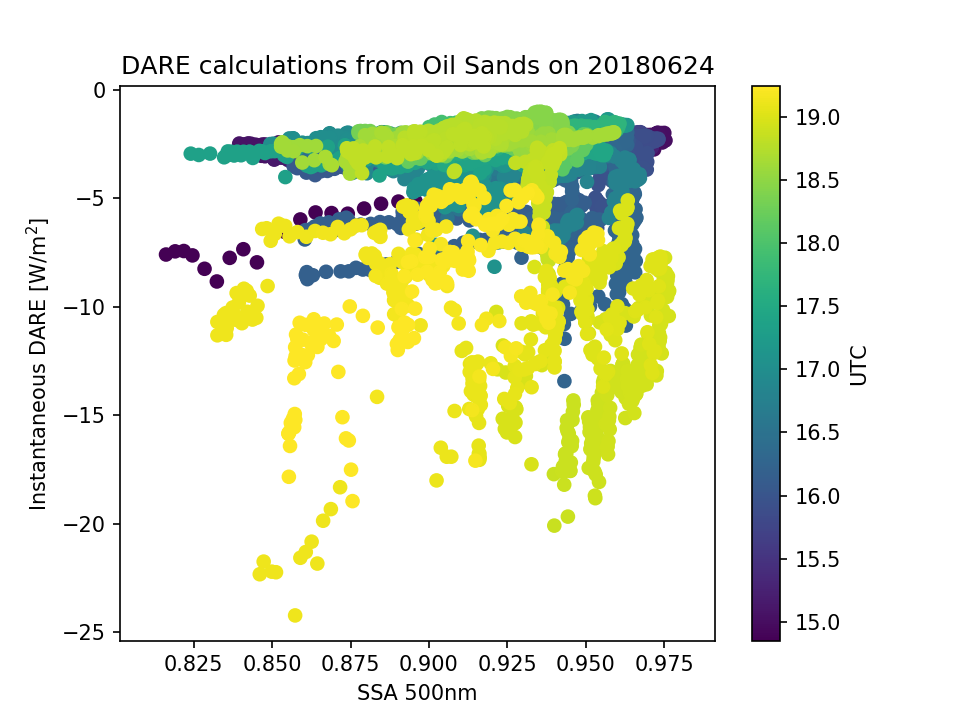

In [186]:
plt.figure()
plt.scatter(out['ssa'][:,0,3],out['dare'][:,0],c=out['utc'])
cb = plt.colorbar()
cb.set_label('UTC')
plt.xlabel('SSA 500nm')
plt.ylabel('Instantaneous DARE [W/m$^2$]')
plt.title('DARE calculations from Oil Sands on {}'.format(day))
plt.savefig(fp+'plots/DARE_vs_SSA_{}.png'.format(day),dpi=600,transparent=True)